In [25]:
import sys
import matplotlib.pyplot as plt
import time
import numpy as np
from pca_classifier import make_figures
from pca_classifier import load_data
from pca_classifier import prepare_data
from pca_classifier import estimate_covariance as cov_est
from pca_classifier import classify
from functools import partial
import os

In [47]:
dataset   = 'mnist'
prep_type = 'noise'
sigma     = 0.05
threshhold= 1e-8
estimator = 'ML'
n_comps   = [8,16,32,128,28*28]
output_dir= '../outputs/'

In [48]:
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

In [49]:
label = dataset+'_'+prep_type+'_'+estimator

In [50]:
if prep_type=='noise':
    prep_data = partial(prepare_data.inpaint_low_var_pixels,noise_level=sigma)
elif prerp_type=='mask':
    prep_data = partial(prepare_data.inpaint_low_var_pixels)

In [51]:
if dataset=='mnist':
    x_train, targets_train, x_test, targets_test = load_data.load_mnist('../data/')
elif dataset=='fmnist':
    x_train, targets_train, x_test, targets_test = load_data.load_fmnist('../data/')

In [52]:
num_classes = len(np.unique(targets_train))
print(num_classes)

10


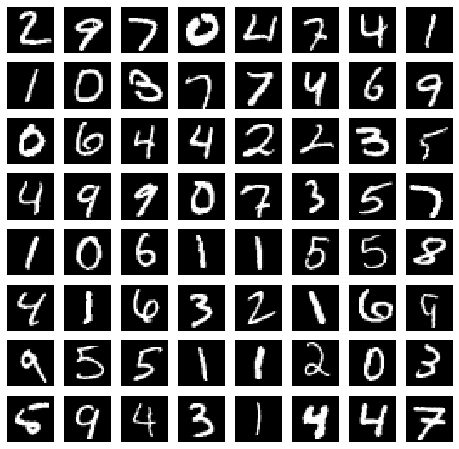

In [53]:
make_figures.make_plots(x_test,'mnist')

In [54]:
train_data = {}
test_data  = {}
for ii in range(num_classes):
    indices = np.where(targets_train==ii)
    train_data[str(ii)]=x_train[indices]
    indices = np.where(targets_test==ii)
    test_data[str(ii)]=x_test[indices]

In [55]:
train_data_prep = {}
shapes = {}
for ii in range(num_classes):
    train_data_prep[str(ii)]=prep_data(train_data[str(ii)],threshhold=threshhold)
    shapes[str(ii)]=train_data_prep[str(ii)][0].shape[0]

In [56]:
covs = {}
for ii in range(num_classes):
    try:
        cov_est.load_covariance(output_dir,label+str(ii),mode)
    except:
        covs[str(ii)] = cov_est.CovarianceEstimator(mode=estimator)
        covs[str(ii)].fit(train_data_prep[str(ii)],label+str(ii))
        covs[str(ii)].decompose()
        covs[str(ii)].save(output_dir)

In [57]:
Cinvs = {}
logdetCs = {}
for ii in range(num_classes):
    Cinvs[str(ii)]={}
    logdetCs[str(ii)]={}
    print(ii)
    for nn in n_comps:
        Cinv, logdetC              = cov_est.get_covariance(covs[str(ii)].R,covs[str(ii)].vars,num=nn,N=None,reg=True)
        Cinvs[str(ii)][str(nn)]    = Cinv
        logdetCs[str(ii)][str(nn)] = logdetC

0
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
1
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
2
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
3
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
4
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
using internal estimate of recon error
5
using interna

In [58]:
acc    = np.zeros((len(n_comps),num_classes))

for n, nn in enumerate(n_comps):
    """
    looping over number of components
    """
    
    for jj in range(num_classes):
        """
        looping over classes
        """ 
        size   = len(test_data[str(jj)])
        px     = np.zeros((num_classes,size))
        for ii in range(num_classes):
            """
            looping over models
            """  
            data = prep_data(test_data[str(jj)],train_data[str(ii)],threshhold=threshhold)
            
            logdet = logdetCs[str(ii)][str(nn)]            
            Cinv   = Cinvs[str(ii)][str(nn)]
            mean   = covs[str(ii)].mean
            
            px[ii]  = classify.get_log_prob(data,logdet,Cinv,mean,vol=True)
        acc[n][jj]  = len(np.where(np.argsort(px,axis=0)[-1]==jj)[0])/np.float(size)

            

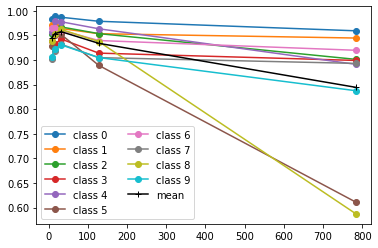

In [63]:
plt.figure()
means = np.mean(acc,axis=1)
for ii in range(num_classes):
    plt.plot(n_comps,acc[:,ii],marker='o',label='class %d'%ii)
plt.plot(n_comps,means,marker='+',color='black',label='mean')
plt.legend(ncol=2)
plt.show()